In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Grid based; Histogram estimators

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import sepp.grid_nonparam

# With real data

In [3]:
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.kernels
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")

In [4]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

The "South" side works okay...

In [5]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [6]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

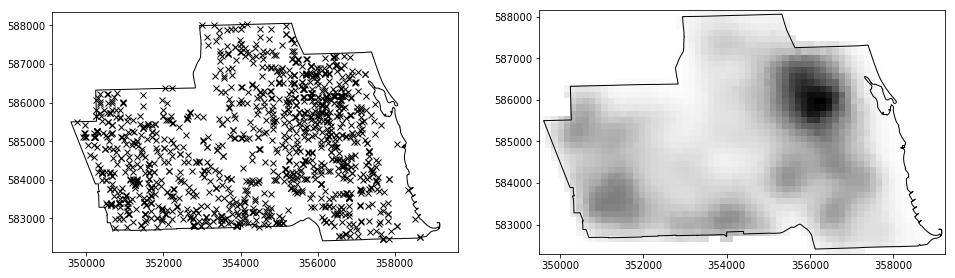

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

# Fit the model

In [8]:
trainer = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=1.5)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=False)

In [9]:
model

ExpDecayModel(T=365.9583333333333, theta=0.018758009793936194, bandwidth=1.5, alpha=[  9.98428782e-01   1.56932097e-03   1.88287749e-06   1.44310139e-08   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00 ... ]

In [10]:
pred = trainer.prediction_from_background(model)

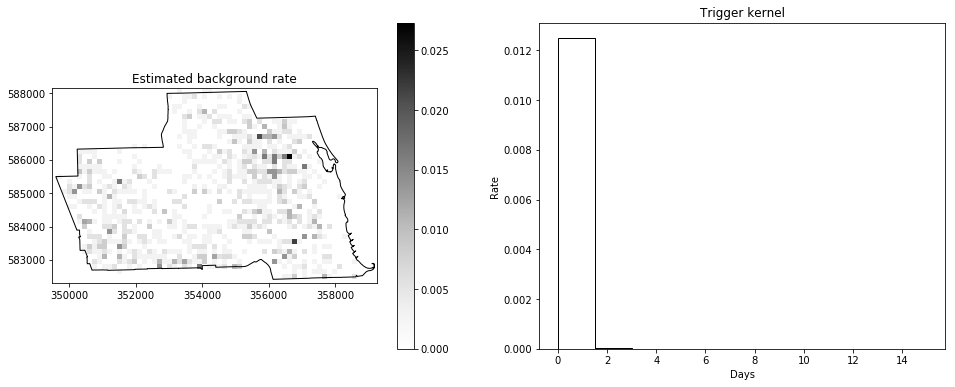

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
mappable = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("Estimated background rate")

ax = axes[1]
x = np.arange(10) * (trainer.time_unit / np.timedelta64(1,"D")) * model.bandwidth
#ax.scatter(x, model.alpha[:len(x)] * model.theta)
ax.set(xlabel="Days", ylabel="Rate", title="Trigger kernel")
ax.bar(x + (x[1] - x[0]) / 2, model.alpha[:len(x)] * model.theta / model.bandwidth,
    model.bandwidth, color="None", edgecolor="black")
#ax.bar(x + (x[1] - x[0]) / 2, model.trigger(None, x), model.bandwidth, color="None", edgecolor="black")
None

In [12]:
np.max(model.mu), np.min(model.mu)

(0.027323395759252505, 0.0)

In [13]:
bandwidths = [0.05, 0.15, 0.3, 1]
models = {}
for b in bandwidths:
    trainer = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=b)
    trainer.data = points
    models[b] = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=False)
    print(b, models[b])

0.05 ExpDecayModel(T=365.9583333333333, theta=0.07381588155518046, bandwidth=0.05, alpha=[  9.53954534e-02   3.98170949e-02   4.07635453e-02   0.00000000e+00   2.00253545e-02   6.57406340e-03   2.12538744e-03   0.00000000e+00   1.58401729e-02   2.35407919e-09 ... ]
0.15 ExpDecayModel(T=365.9583333333333, theta=0.03675265199097048, bandwidth=0.15, alpha=[  3.43341301e-01   6.65242612e-02   1.41353662e-02   7.53563761e-02   1.27195188e-05   0.00000000e+00   0.00000000e+00   2.54831116e-02   0.00000000e+00   7.70209530e-04 ... ]
0.3 ExpDecayModel(T=365.9583333333333, theta=0.023762136518131863, bandwidth=0.3, alpha=[  6.36824373e-01   1.53963443e-01   0.00000000e+00   1.17826336e-03   3.62217129e-09   1.95078611e-02   7.26231485e-02   0.00000000e+00   4.52310166e-12   2.23112614e-02 ... ]
1 ExpDecayModel(T=365.9583333333333, theta=0.019715760080525144, bandwidth=1, alpha=[  9.05028521e-01   8.80855533e-02   2.15285608e-07   6.79544275e-03   0.00000000e+00   9.02672260e-05   0.00000000e+00

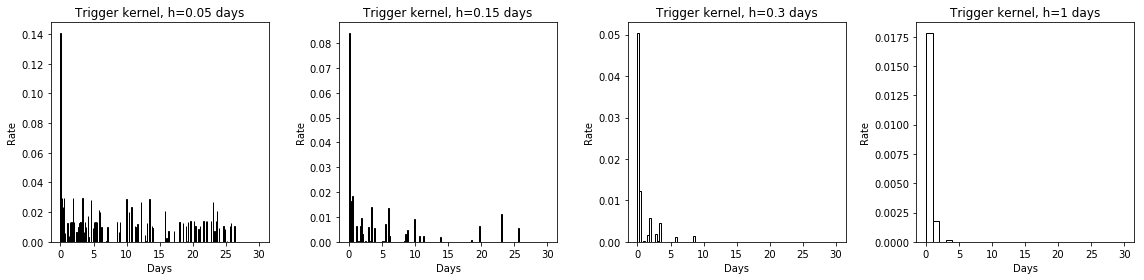

In [14]:
fig, axes = plt.subplots(ncols=4, figsize=(16,4))

for ax, (b, model), s in zip(axes, models.items(), [600,200,100,30]):
    x = np.arange(s) * (trainer.time_unit / np.timedelta64(1,"D")) * model.bandwidth
    ax.set(xlabel="Days", ylabel="Rate", title="Trigger kernel, h={} days".format(b))
    ax.bar(x + (x[1] - x[0]) / 2, model.alpha[:len(x)] * model.theta / model.bandwidth,
           model.bandwidth, color="None", edgecolor="black")
fig.tight_layout()
fig.savefig("../north_trigger.pdf")

In [15]:
bandwidths = [0.05, 0.15, 0.3, 1]
models = {}
for b in bandwidths:
    trainer = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=b)
    trainer.data = points
    models[b] = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=True)
    print(b, models[b])

0.05 ExpDecayModel(T=365.9583333333333, theta=0.11644601545461213, bandwidth=0.05, alpha=[  1.16971851e-01   2.52395756e-02   2.58425018e-02   2.20697150e-15   1.26942038e-02   4.16735094e-03   2.43113048e-03   0.00000000e+00   1.00074749e-02   2.10316531e-09 ... ]
0.15 ExpDecayModel(T=365.9583333333333, theta=0.04392144930025733, bandwidth=0.15, alpha=[  4.40803911e-01   5.44899003e-02   1.18122358e-02   6.19900081e-02   1.28603596e-05   0.00000000e+00   3.49101409e-32   2.06056441e-02   2.28859559e-20   6.02337193e-04 ... ]
0.3 ExpDecayModel(T=365.9583333333333, theta=0.030157021659100863, bandwidth=0.3, alpha=[  7.25966715e-01   1.19698122e-01   1.09873574e-19   7.71312571e-04   1.56476867e-09   1.48651990e-02   5.66079824e-02   0.00000000e+00   2.38604590e-12   1.66642329e-02 ... ]
1 ExpDecayModel(T=365.9583333333333, theta=0.02676614578439982, bandwidth=1, alpha=[  9.35197169e-01   6.13669630e-02   1.25229437e-07   3.39954869e-03   9.85565307e-21   3.61941867e-05   1.15460796e-28 

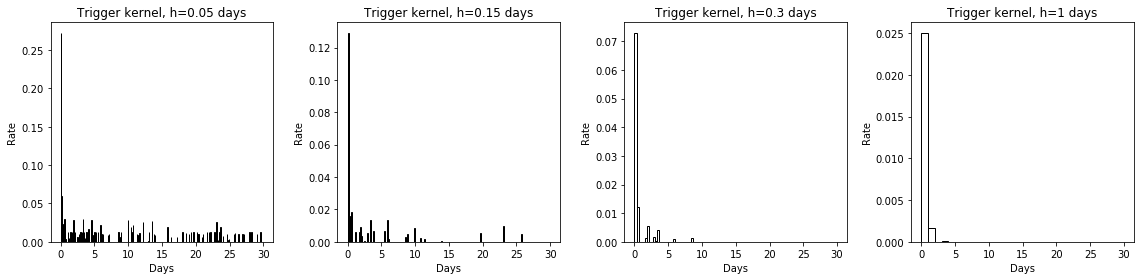

In [16]:
fig, axes = plt.subplots(ncols=4, figsize=(16,4))

for ax, (b, model), s in zip(axes, models.items(), [600,200,100,30]):
    x = np.arange(s) * (trainer.time_unit / np.timedelta64(1,"D")) * model.bandwidth
    ax.set(xlabel="Days", ylabel="Rate", title="Trigger kernel, h={} days".format(b))
    ax.bar(x + (x[1] - x[0]) / 2, model.alpha[:len(x)] * model.theta / model.bandwidth,
           model.bandwidth, color="None", edgecolor="black")
fig.tight_layout()

# Other regions of chicago

In [17]:
sides = ["Far North", "Northwest", "North", "West", "Central",
    "South", "Southwest", "Far Southwest", "Far Southeast"]

In [18]:
def load(side):
    geo = open_cp.sources.chicago.get_side(side)
    grid = open_cp.data.Grid(150, 150, 0, 0)
    grid = open_cp.geometry.mask_grid_by_intersection(geo, grid)
    mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
    points = all_points[mask]
    points = open_cp.geometry.intersect_timed_points(points, geo)
    return grid, points

In [19]:
bandwidths = [0.05, 0.15, 0.3, 1]

models = {}
for side in sides:
    grid, points = load(side)
    models[side] = {}
    for b in bandwidths:
        trainer = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=b)
        trainer.data = points
        try:
            models[side][b] = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=False)
        except ValueError as ex:
            #print("Failed because {} for {}/{}".format(ex, side, b))
            print("Failed: {}/{}".format(side, b))
            models[side][b] = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=True)

Failed: Far North/0.05
Failed: Far North/0.15
Failed: Far North/0.3
Failed: Far North/1
Failed: Northwest/0.05
Failed: Northwest/0.15
Failed: Northwest/0.3
Failed: Northwest/1
Failed: West/0.05
Failed: West/0.15
Failed: West/0.3
Failed: West/1
Failed: Southwest/0.05
Failed: Southwest/0.15
Failed: Southwest/0.3
Failed: Southwest/1
Failed: Far Southwest/0.05
Failed: Far Southwest/0.15
Failed: Far Southwest/0.3
Failed: Far Southwest/1
Failed: Far Southeast/0.05
Failed: Far Southeast/0.15
Failed: Far Southeast/0.3
Failed: Far Southeast/1


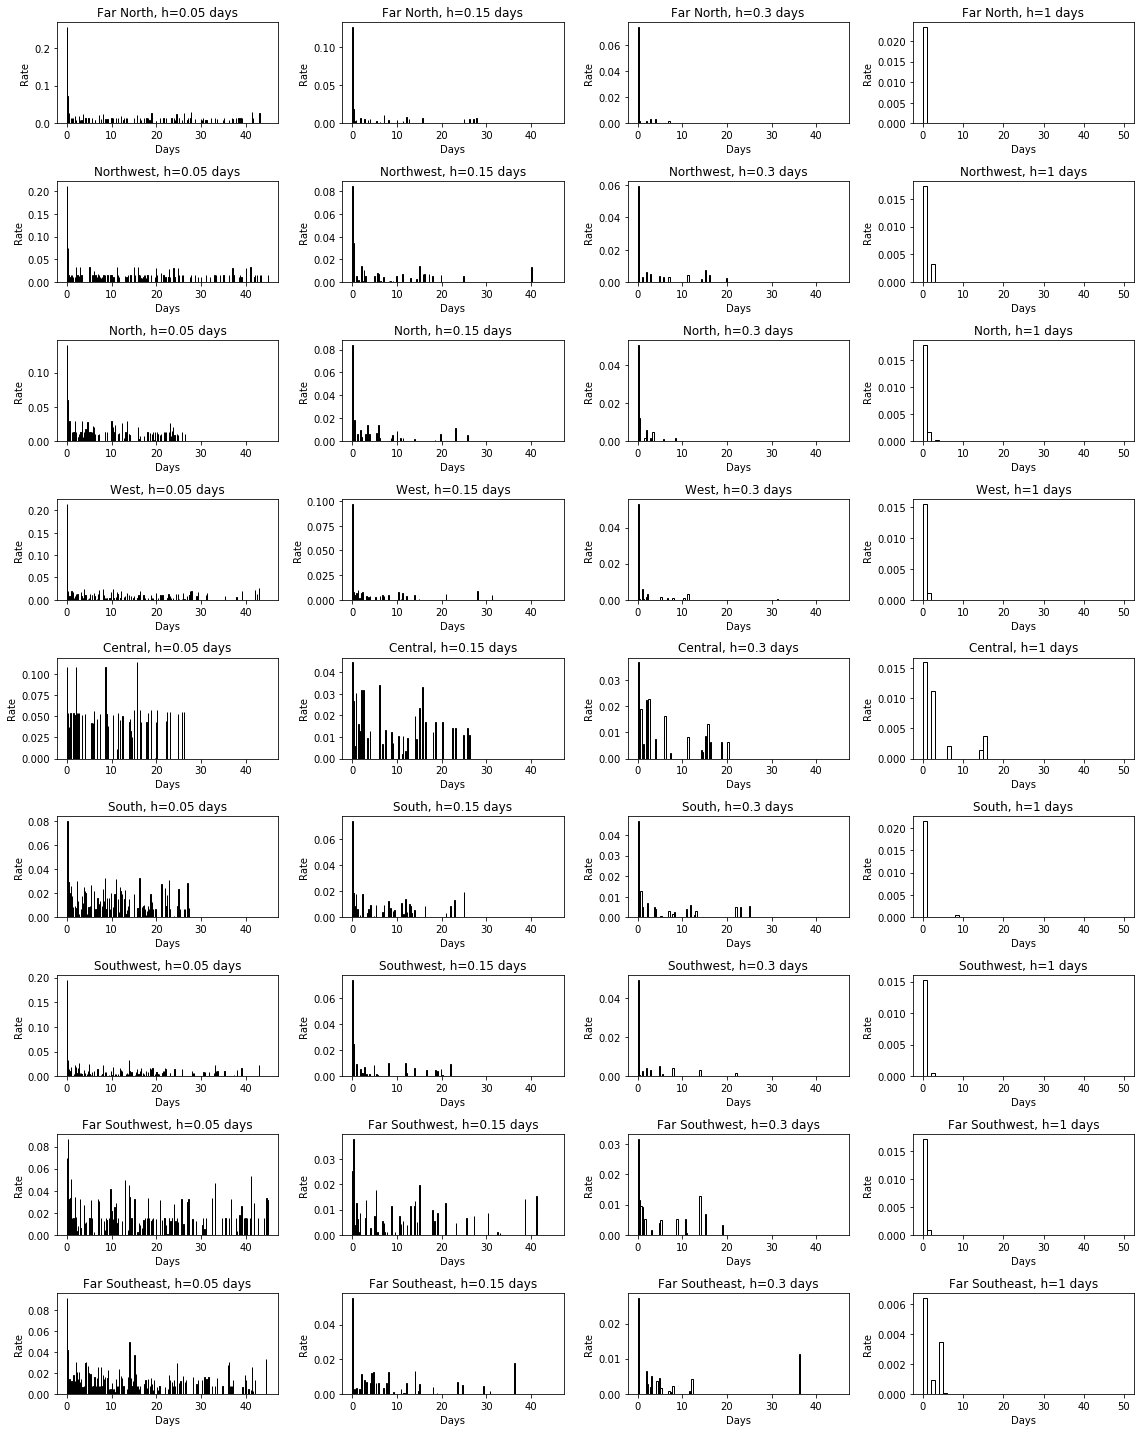

In [20]:
fig, axes = plt.subplots(ncols=4, nrows=len(sides), figsize=(16,20))

for side, axe in zip(sides, axes):
    for ax, bw, s in zip(axe, models[side], [900,300,150,50]):
        model = models[side][bw]
        x = np.arange(s) * (trainer.time_unit / np.timedelta64(1,"D")) * model.bandwidth
        ax.set(xlabel="Days", ylabel="Rate", title="{}, h={} days".format(side, bw))
        ax.bar(x + (x[1] - x[0]) / 2, model.alpha[:len(x)] * model.theta / model.bandwidth,
               model.bandwidth, color="None", edgecolor="black")

fig.tight_layout()